In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

import torch
import torch.nn as nn

import models

from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)
embedder = SentenceTransformer('all-MiniLM-L6-v2')

filename = 'classifier_29k_11242024_191324.pth'
model = models.Classifier.load_model(filename).to(device)

class FirstLayerExtractor(nn.Module):
    def __init__(self, original_model):
        super(FirstLayerExtractor, self).__init__()
        self.fc1 = original_model.fc1

    def forward(self, x):
        output = self.fc1(x)  # Pass through the first layer
        return torch.nn.functional.normalize(output, p=2, dim=-1)  # Normalize the output

# Wrap the model to use only the first layer
first_layer_model = FirstLayerExtractor(model).to(device)


data = dict()
folders = ['all_gpt_summaries', 'all_philosophize_this_transcripts', 'all_source_texts', 'all_wikipedias']
# folders = ['all_gpt_summaries']
# folders = ['select_all_texts']

for folder in folders:
    data_folder = os.path.join('data', 'all_texts', folder)
    for filename in os.listdir(data_folder):
        filepath = os.path.join(data_folder, filename)
        tensors = []

        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
        chunks = splitter.split_text(text)
        embeddings = embedder.encode(chunks)


        for embedding in embeddings:
            with torch.no_grad():
                embedding = torch.tensor(embedding).to(device)
                embedding = first_layer_model(embedding).cpu()
            tensors.append(embedding)

        tensor_stack = torch.stack(tensors, dim=1)
        mean_tensor = tensor_stack.mean(dim=1)
        data[filename] = mean_tensor

c:\Users\lucas\Desktop\UCSD\256\philosophical_oracle\models\classifier.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load(filepath)


Model loaded from model_weights\classifier_29k_11242024_191324.pth


In [ ]:
filename_to_category = {
    "aurelius_meditations.txt": "Stoicism",
    "beauvoir_ethicsambiguity.txt": "Existentialism",
    "buddha_stanford_pe.txt": "Buddhism",
    "camus_sisyphus.txt": "Absurdism",
    "camus_thestranger.txt": "Absurdism",
    "confucius_analects.txt": "Confucianism",
    "emerson_selfreliance.txt": "Transcendentalism",
    "epicurus_fragments.txt": "Epicureanism",
    "epicurus_lettermenoeceus.txt": "Epicureanism",
    "essence_of_buddha.txt": "Buddhism",
    "kierkegaard_presentage.txt": "Existentialism",
    "laozi_taoteching.txt": "Taoism",
    "leibniz_theodicity.txt": "Rationalism",
    "nietzsche_tsz.txt": "Existentialism",
    "spinoza_ethics.txt": "Rationalism",
    "thoreau_walden.txt": "Transcendentalism",
    "absurdism_wikipedia.txt": "Absurdism",
    "buddhism_wikipedia.txt": "Buddhism",
    "confucianism_wikipedia.txt": "Confucianism",
    "effectivealtruism_wikipedia.txt": "Effective Altruism",
    "epicureanism_wikipedia.txt": "Epicureanism",
    "existentialism_wikipedia.txt": "Existentialism",
    "rationalism_wikipedia.txt": "Rationalism",
    "stoicism_wikipedia.txt": "Stoicism",
    "taoism_wikipedia.txt": "Taoism",
    "transcendentalism_wikipedia.txt": "Transcendentalism",
    "gpt_beauvoir.txt": "Existentialism",
    "gpt_buddhism.txt": "Buddhism",
    "gpt_camus.txt": "Absurdism",
    "gpt_emerson.txt": "Transcendentalism",
    "gpt_epicureanism.txt": "Epicureanism",
    "gpt_kierkegaard.txt": "Existentialism",
    "gpt_leibniz.txt": "Rationalism",
    "gpt_nietzsche.txt": "Existentialism",
    "gpt_spinoza.txt": "Rationalism",
    "gpt_stoicism.txt": "Stoicism",
    "gpt_thoreau.txt": "Transcendentalism",
    "philthis_beauvoir.txt": "Existentialism",
    "philthis_buddhism.txt": "Buddhism",
    "philthis_camus.txt": "Absurdism",
    "philthis_emerson.txt": "Transcendentalism",
    "philthis_epicurus.txt": "Epicureanism",
    "philthis_kierkegaard.txt": "Existentialism",
    "philthis_leibniz.txt": "Rationalism",
    "philthis_nietzsche.txt": "Existentialism",
    "philthis_spinoza.txt": "Rationalism",
    "philthis_stoicism.txt": "Stoicism",
    "philthis_thoreau.txt": "Transcendentalism",
}

In [4]:
def plot_pca_3d(data, filename_to_category, title="PCA 3D Plot"):
    """
    Conducts PCA on a list of tensor vectors and plots the result in a 3D interactive chart.
    
    Args:
        data (dict): A dictionary with 'filename: tensor' pairs.
        filename_to_category (dict): A dictionary mapping filenames to categories (labels).
        title (str): The title of the plot.
    """
    # Aggregate tensors and metadata
    filenames = []
    categories = []
    tensors = []
    
    for filename, tensor in data.items():
        filenames.append(filename)
        categories.append(filename_to_category[filename])
        tensors.append(tensor.numpy())  # Convert to NumPy array for PCA

    # Stack tensors into a matrix for PCA
    tensor_matrix = np.stack(tensors)  # Shape: [num_files, 384]

    # Perform PCA to reduce dimensions to 3
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(tensor_matrix)  # Shape: [num_files, 3]

    # Create a DataFrame for plotting
    import pandas as pd
    plot_data = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'PC3': pca_result[:, 2],
        'Filename': filenames,
        'Category': categories
    })

    # Plot using Plotly for interactivity
    fig = px.scatter_3d(
        plot_data,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Category',  # Color by category
        hover_name='Filename',  # Show filename on hover
        title=title
    )
    
    fig.update_traces(marker=dict(size=5))  # Adjust marker size
    fig.update_layout(
        scene=dict(
            xaxis_title='PC 1',
            yaxis_title='PC 2',
            zaxis_title='PC 3'
        ),
        width=1200,  # Set plot width
        height=800   # Set plot height
    )

    fig.show()


plot_pca_3d(data, filename_to_category, title="PCA Visualization of Source Texts")

C:\Users\lucas\AppData\Local\Temp\ipykernel_30556\3630624649.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



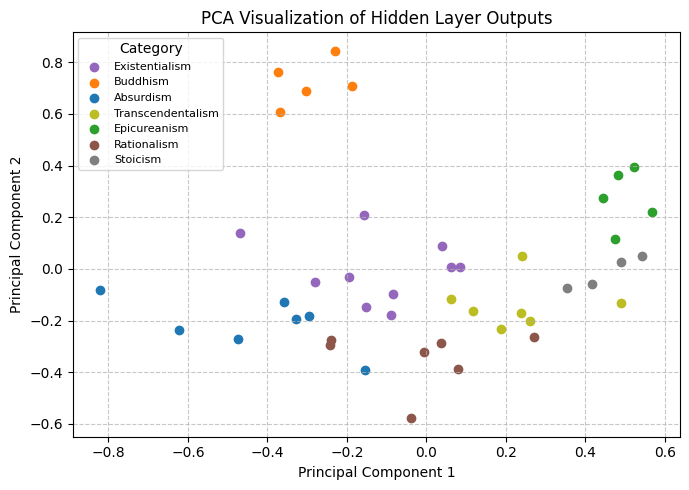

In [5]:
from matplotlib.cm import get_cmap


def plot_pca_2d(data, filename_to_category, title="PCA 2D Plot"):
    """
    Conducts PCA on a list of tensor vectors and plots the result in a 2D chart using Matplotlib.
    
    Args:
        data (dict): A dictionary with 'filename: tensor' pairs.
        filename_to_category (dict): A dictionary mapping filenames to categories (labels).
        title (str): The title of the plot.
    """
    # Aggregate tensors and metadata
    filenames = []
    categories = []
    tensors = []
    
    for filename, tensor in data.items():
        filenames.append(filename)
        categories.append(filename_to_category[filename])
        tensors.append(tensor.numpy())  # Convert to NumPy array for PCA

    # Stack tensors into a matrix for PCA
    tensor_matrix = np.stack(tensors)  # Shape: [num_files, 384]

    # Perform PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(tensor_matrix)  # Shape: [num_files, 2]

    # Create a mapping of unique categories to colors
    unique_categories = sorted(set(categories))
    cmap = get_cmap('tab10')  # A color map with clear distinct colors
    category_to_color = {category: cmap(i / len(unique_categories)) for i, category in enumerate(unique_categories)}

    # Plot PCA results
    plt.figure(figsize=(7, 5))
    for i, (pc1, pc2) in enumerate(pca_result):
        category = categories[i]
        color = category_to_color[category]
        plt.scatter(pc1, pc2, color=color, label=category if category not in plt.gca().get_legend_handles_labels()[1] else "")
        # plt.text(pc1, pc2, filenames[i], fontsize=8, alpha=0.7)

    # Add legend and labels
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Category", loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_pca_2d(data, filename_to_category, title="PCA Visualization of Hidden Layer Outputs")